In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from raptor_utils import *
import networkx as nx

In [39]:
stops_df[stop_]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,plc_url,location_type,parent_station
0,LAKE,NaN,Lake Merritt,NaN,37.797357,-122.265232,LAKE,NaN,0,place_LAKE
1,FTVL,NaN,Fruitvale,NaN,37.774873,-122.224067,FTVL,NaN,0,place_FTVL
2,COLS,NaN,Coliseum,NaN,37.753604,-122.196698,COLS,NaN,0,place_COLS
3,SANL,NaN,San Leandro,NaN,37.721806,-122.160713,SANL,NaN,0,place_SANL
4,BAYF,NaN,Bay Fair,NaN,37.696938,-122.126431,BAYF,NaN,0,place_BAYF
...,...,...,...,...,...,...,...,...,...,...
223,WCRK_1,NaN,Enter/Exit : Station entrance,Enter/Exit : Station entrance,37.905567,-122.067623,NaN,NaN,2,place_WCRK
224,WDUB_1,NaN,Enter/Exit : Station entrance,Enter/Exit : Station entrance,37.699919,-121.927889,NaN,NaN,2,place_WDUB
225,WDUB_2,NaN,Enter/Exit : Station entrance,Enter/Exit : Station entrance,37.699659,-121.928316,NaN,NaN,2,place_WDUB
226,WOAK_1,NaN,Enter/Exit: Station Access,Station Access,37.805029,-122.295302,NaN,NaN,2,place_WOAK


In [21]:
file_path = '/Users/theomacmillan/Downloads/google_transit_20250113-20250808_v03'
stop_times_df = pd.read_csv(file_path + '/stop_times.txt')
transfers_df = pd.read_csv(file_path + '/transfers.txt')
stops_df = pd.read_csv(file_path + '/stops.txt')

In [18]:
# convert stop_times_df arrival and departure times to seconds
def time_to_seconds(time):
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: time_to_seconds(x))
stop_times_df['departure_time'] = stop_times_df['departure_time'].apply(lambda x: time_to_seconds(x))

In [34]:
class Subway:
    def __init__(self, stop_times_df, stops_df, transfers_df):
        self.unique_stop_ids = set([stop[:3] for stop in stops_df.stop_id])
        self.time_table = stop_times_df.copy()
        self.stops_df = stops_df.copy()
        self.transfers_df = transfers_df.copy()

        ## prune time table a little bit
        # self.time_table['stop_id'] = self.time_table['stop_id'].apply(lambda x: x[:3])

        # if arrival time has time greater than 23:00, mod it by 24 hours in string form
        self.time_table['arrival_time'] = self.time_table['arrival_time'].apply(lambda x: x if int(x[:2]) < 24 else str(int(x[:2]) % 24) + x[2:])
        self.time_table['departure_time'] = self.time_table['departure_time'].apply(lambda x: x if int(x[:2]) < 24 else str(int(x[:2]) % 24) + x[2:])

        self.time_table['arrival_time'] = pd.to_datetime(self.time_table['arrival_time'])
        self.time_table['departure_time'] = pd.to_datetime(self.time_table['departure_time'])
        
        self.stop_id_to_index = {stop_id: i for i, stop_id in enumerate(self.unique_stop_ids)}

    def generate_links(self):
        # generates a link between two station whenever you can take a train from one to the other and stores the result in a dataframe
        # the 'weight' is a timedelta object of how long it takes to travel between the two
        #self.link_df = pd.DataFrame(columns=['departing_station', 'arriving_station', 'travel_time'])
        self.links = {}
        
        # trains between stations
        for i,row in self.time_table.iterrows():
            if i == 0:
                continue
            if self.time_table.loc[i-1, 'trip_id'] == row['trip_id']:
                if self.time_table.loc[i-1, 'stop_id'] != row['stop_id']:
                    # we are at the same trip and we are at different stops
                    # we can add a link between the two
                    # append link to link_df
                    self.links[(self.time_table.loc[i-1, 'stop_id'], row['stop_id'])] = (row['arrival_time'] - self.time_table.loc[i-1, 'departure_time']).seconds
                    self.links[(row['stop_id'], self.time_table.loc[i-1, 'stop_id'])] = (row['arrival_time'] - self.time_table.loc[i-1, 'departure_time']).seconds
        
        #transfers between stations
        for i,row in self.transfers_df.iterrows():
            if row['from_stop_id'] in self.unique_stop_ids and row['to_stop_id'] in self.unique_stop_ids:
                self.links[(row['from_stop_id'], row['to_stop_id'])] = int(row['min_transfer_time'])
                self.links[(row['to_stop_id'], row['from_stop_id'])] = int(row['min_transfer_time'])


        self.links_df = pd.DataFrame(subway.links.items(), columns=['station_pair', 'travel_time'])

        return
    
    def generate_graph(self):
        G = nx.Graph()
        
        # get the MINIMUM travel time between two stations
        self.links_df = self.links_df.groupby('station_pair').travel_time.min().reset_index()

        for i, row in subway.links_df.iterrows():
            G.add_edge(row['station_pair'][0], row['station_pair'][1], weight=row['travel_time'])

        for node in G.nodes:
            row = stops_df[self.stops_df.stop_id == node]
            G.nodes[node]['pos'] = (row.stop_lon.values[0], row.stop_lat.values[0])

        self.graph = G
    
        # remove self edges
        self.graph.remove_edges_from([(u, v) for u, v in self.graph.edges() if u == v])

        return

subway = Subway(stop_times_df, stops_df, transfers_df)
subway.generate_links()
subway.generate_graph()

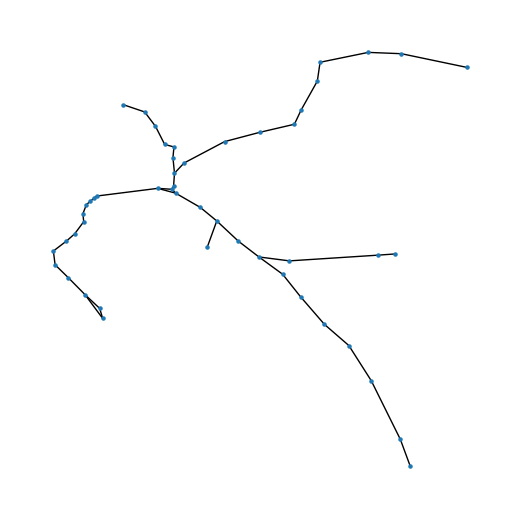

In [35]:
# Retrieve updated positions from the graph
pos = nx.get_node_attributes(subway.graph, 'pos')

plt.figure(figsize=(5, 5))
nx.draw(subway.graph, pos, with_labels=False, node_size=5, font_size=10, font_color="blue")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [36]:
subway.graph.nodes()

NodeView(('12TH', '19TH', 'LAKE', 'WOAK', '16TH', '24TH', 'CIVC', 'MCAR', 'GLEN', 'ANTC', 'PCTR', 'ASHB', 'DBRK', 'BALB', 'DALY', 'BAYF', 'CAST', 'HAYW', 'SANL', 'BERY', 'MLPT', 'WDUB', 'POWL', 'COLM', 'SSAN', 'COLS', 'FTVL', 'OAKL', 'CONC', 'NCON', 'PHIL', 'NBRK', 'DELN', 'PLZA', 'RICH', 'DUBL', 'EMBR', 'MONT', 'FRMT', 'UCTY', 'WARM', 'SHAY', 'LAFY', 'ORIN', 'WCRK', 'ROCK', 'MLBR', 'SBRN', 'SFIA', 'PITT'))

In [37]:
travel_times = dict(nx.all_pairs_dijkstra_path_length(subway.graph))

In [38]:
def solve_tsp(starting_station, G):
    def create_data_model():
        """Stores the data for the problem."""
        data = {}

        node_list = list(G.nodes)
        all_to_all_weights = dict(nx.all_pairs_dijkstra_path_length(G))
        cost_dict = all_to_all_weights
        cost_matrix = np.ones((len(cost_dict), len(cost_dict)), dtype=int)*100000

        for key, val in cost_dict.items():
            for k, v in val.items():
                cost_matrix[node_list.index(key), node_list.index(k)] = int(v)

        data["distance_matrix"] = cost_matrix
        data["num_vehicles"] = 1
        data["depot"] = node_list.index(starting_station)
        return data


    def print_solution(manager, routing, solution):
        """Prints solution on console."""
        print(f"Objective: {solution.ObjectiveValue()/60/60} hours")
        index = routing.Start(0)
        #plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        route = []
        node_list = list(G.nodes)
        while not routing.IsEnd(index):
            #plan_output += f" {node_list[manager.IndexToNode(index)]} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
            #print(manager.IndexToNode(previous_index))
            route.append(node_list[manager.IndexToNode(previous_index)])
        #plan_output += f" {manager.IndexToNode(index)}\n"
        #print(plan_output)
        #plan_output += f"Route distance: {route_distance}miles\n"
        return route, solution.ObjectiveValue()/60/60


    def main():
        """Entry point of the program."""
        # Instantiate the data problem.
        data = create_data_model()

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            #print(data["distance_matrix"][from_node][to_node])
            return data["distance_matrix"][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # Print solution on console.
        if solution:
            route, route_time = print_solution(manager, routing, solution)
            return route, route_time
        
    route, route_time = main()
    return route, route_time

or_tools_route, or_tools_route_time = solve_tsp('ANTC', subway.graph)

Objective: 6.1 hours
